<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/HR_cHsJcbMpL-g)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [1]:
DATA_PATH = ''
%matplotlib inline

# For Google Colab only:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
#from reco_utils.recommender.sar.sar_singlenode import SARSingleNode
from google.colab import drive
drive.mount('/content/gdrive')

DATA_PATH = 'gdrive/My Drive/Colab Notebooks/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import json

# загружаем датасет
img_codes = np.load("gdrive/My Drive/proj/data/image_codes.npy")
captions = json.load(open('gdrive/My Drive/proj/data/captions_tokenized.json'))

In [3]:
!ls gdrive/"My Drive"/proj/

data  handout.tar.gz  inception_v3_google-1a9a5a14.pth


In [4]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [5]:
import nltk
from collections import Counter
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [7]:
counter = Counter()
max_len = 0
for i, sent in enumerate(captions):
  res = max(len(ele) for ele in sent) 
  sen = ' '.join(sent).lower()
  if res > max_len:
    max_len = res
  tokens = nltk.tokenize.word_tokenize(sen)
  counter.update(tokens)
  if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(captions)))

[1000/118287] Tokenized the captions.
[2000/118287] Tokenized the captions.
[3000/118287] Tokenized the captions.
[4000/118287] Tokenized the captions.
[5000/118287] Tokenized the captions.
[6000/118287] Tokenized the captions.
[7000/118287] Tokenized the captions.
[8000/118287] Tokenized the captions.
[9000/118287] Tokenized the captions.
[10000/118287] Tokenized the captions.
[11000/118287] Tokenized the captions.
[12000/118287] Tokenized the captions.
[13000/118287] Tokenized the captions.
[14000/118287] Tokenized the captions.
[15000/118287] Tokenized the captions.
[16000/118287] Tokenized the captions.
[17000/118287] Tokenized the captions.
[18000/118287] Tokenized the captions.
[19000/118287] Tokenized the captions.
[20000/118287] Tokenized the captions.
[21000/118287] Tokenized the captions.
[22000/118287] Tokenized the captions.
[23000/118287] Tokenized the captions.
[24000/118287] Tokenized the captions.
[25000/118287] Tokenized the captions.
[26000/118287] Tokenized the capti

In [0]:
words = [word for word, cnt in counter.items() if cnt > 5]
vocab = Vocabulary()
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')

    # Add the words to the vocabulary.
for i, word in enumerate(words):
  vocab.add_word(word)

In [10]:
captions_token = []
targets = torch.zeros(len(captions), 5, max_len).long()

for i, sent in enumerate(captions):
  if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(captions)))
  #i *= 5
  for j in range(len(sent)):
    tokens = nltk.tokenize.word_tokenize(sent[j].lower())
    caption = []
    caption.append(vocab('<start>'))
    caption.extend([vocab(token) for token in tokens])
    caption.append(vocab('<end>'))
    #while len(caption) < max_len:
    #  caption.append('<unk>')
    caption = torch.Tensor(caption)
    #targets[i+j, :len(caption)] = caption
    targets[i, j, :len(caption)] = caption

[1000/118287] Tokenized the captions.
[2000/118287] Tokenized the captions.
[3000/118287] Tokenized the captions.
[4000/118287] Tokenized the captions.
[5000/118287] Tokenized the captions.
[6000/118287] Tokenized the captions.
[7000/118287] Tokenized the captions.
[8000/118287] Tokenized the captions.
[9000/118287] Tokenized the captions.
[10000/118287] Tokenized the captions.
[11000/118287] Tokenized the captions.
[12000/118287] Tokenized the captions.
[13000/118287] Tokenized the captions.
[14000/118287] Tokenized the captions.
[15000/118287] Tokenized the captions.
[16000/118287] Tokenized the captions.
[17000/118287] Tokenized the captions.
[18000/118287] Tokenized the captions.
[19000/118287] Tokenized the captions.
[20000/118287] Tokenized the captions.
[21000/118287] Tokenized the captions.
[22000/118287] Tokenized the captions.
[23000/118287] Tokenized the captions.
[24000/118287] Tokenized the captions.
[25000/118287] Tokenized the captions.
[26000/118287] Tokenized the capti

In [11]:
captions[1]

['a person skiing down a steep hill',
 'a person skiing down a steep snowy hill .',
 'a person on snow skis going down a steep slope .',
 'a skier is skiing down a down hill slope .',
 'a skier is shown taking on a very steep slope .']

In [12]:
vocab.idx2word[30]

'skiing'

In [13]:
targets[0]

tensor([[ 1,  4,  5,  ...,  0,  0,  0],
        [ 1,  7,  8,  ...,  0,  0,  0],
        [ 1,  4, 17,  ...,  0,  0,  0],
        [ 1, 21, 16,  ...,  0,  0,  0],
        [ 1,  4, 27,  ...,  0,  0,  0]])

### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence

In [0]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens, emb_size=256, lstm_units=512, cnn_feature_size=2048):
        super(self.__class__, self).__init__()
        
        # два линейных слоя, которые будут из векторов, полученных на выходе Inseption, 
        # получать начальные состояния h0 и c0 LSTM-ки, которую мы потом будем 
        # разворачивать во времени и генерить ею текст
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # вот теперь recurrent part

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.embed = nn.Embedding(n_tokens, emb_size)
            
        # lstm: настакайте LSTM-ок (1 или более, но не надо сразу пихать больше двух, замечаетесь ждать).
        self.lstm = nn.LSTM(emb_size, lstm_units, 1, batch_first=True, dropout=0.2)
            
        # ну и линейный слой для получения логитов
        self.linear = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержаший выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # 
        embeddings = self.embed(captions_ix)
        #embeddings = torch.cat((image_vectors.unsqueeze(1), embeddings), 1)
        #packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(embeddings, (initial_cell.unsqueeze(0),initial_hid.unsqueeze(0)))
        hiddens = hiddens.transpose(0,1)
        # применим LSTM:
        # 1. инициализируем lstm state с помощью initial_* (сверху)
        # 2. скормим LSTM captions_emb
        # 3. посчитаем логиты из выхода LSTM
        
         # shape: [batch, caption_length, lstm_units]
        
       
        logits = self.linear(hiddens.view(hiddens.size(0)*hiddens.size(1), hiddens.size(2)))
        
        return logits.view(hiddens.size(0), hiddens.size(1), logits.size(1))        

In [60]:
device = "cuda"
network = CaptionNet(len(vocab.idx2word)).to(device)
crit = nn.CrossEntropyLoss()#(ignore_index=0)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
def compute_loss(network, image_vectors, captions_ix, crit):
    """
    :param image_vectors: torch tensor c выходами inception. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor с описаниями (в виде матрицы). shape: [batch, word_i]. 
    
    :returns: scalar crossentropy loss (neg log likelihood) for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
   
    captions_ix_inp = captions_ix[:, :-1]
    captions_ix_next = captions_ix[:, 1:].contiguous().transpose(0,1).reshape(-1)
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    #print(logits_for_next.shape, captions_ix_next.shape)
    loss = crit(logits_for_next.view(-1, len(vocab)), captions_ix_next)

    # compute the loss function between logits_for_next and captions_ix_next
    # ВАЖНО: не забудтье, что PADDING не должен влиять на лосс -- лосс должен склыдваться
    # только из тех мест, где должно быть предсказано слово, а не PAD
    # это можно сделать либо заведя маску из нулей и единиц (captions_ix_next != pad_ix) и умножить на нее лосс,
    # либо просто используя ignore_index, который в торче есть как аргумент у некоторых лоссов.
    
    return loss

In [0]:
params = network.parameters()
optimizer = torch.optim.Adam(params, lr=0.1)

Поделим выборку на train/test:

In [0]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, targets,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [0]:
# batch generator. Можно заменить на свой/переделать этот
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    #captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    #batch_captions = map(choice,captions_for_batch_images)
    ix = np.random.randint(0, 5, size=batch_size)
    batch_captions = captions[random_image_ix, ix]
    #convert to matrix
    #batch_captions_ix = <YOUR CODE>
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions, dtype=torch.int64)
    

In [19]:
generate_batch(img_codes, targets, 4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(tensor([[0.0882, 0.3501, 0.2551,  ..., 0.0695, 0.3763, 0.6839],
         [0.0687, 0.4325, 0.2952,  ..., 0.1024, 0.8728, 0.8133],
         [0.1990, 0.4397, 0.2479,  ..., 0.1416, 0.4944, 0.6154],
         [0.7155, 0.1600, 0.3112,  ..., 0.0412, 0.7781, 0.1242]]),
 tensor([[   1, 3485,   43,  ...,    0,    0,    0],
         [   1,   88,    4,  ...,    0,    0,    0],
         [   1,   24,  908,  ...,    0,    0,    0],
         [   1,   45,  277,  ...,    0,    0,    0]]))

In [20]:
targets.shape

torch.Size([118287, 5, 258])

In [21]:
img_codes[0].shape

(2048,)

## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [65]:
def train(network, img_codes, targets, optimizer, crit):
  batch_size = 100
  num_epochs = 10
  total_step = len(img_codes)
  for epoch in range(num_epochs):
    i = 0
    ll = 0
    c = 0
    while i < total_step:
      network.zero_grad()
      i+= batch_size
      X_batch, y_batch = generate_batch(img_codes, targets, batch_size)
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)
      #_, X_batch, _ = inception(X_batch)
      #outputs = network(X,batch)
      loss = compute_loss(network, X_batch, y_batch, crit)
      loss.backward()
      optimizer.step()
      ll += loss
      #if i % 10000 == 0:
      #  print(ll/10000)
      #  ll = 0
      c+=1
    if epoch % 3 == 0:
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
              .format(epoch, num_epochs, i, total_step, ll/c))
        
#network = CaptionNet(len(vocab.idx2word)).to(device)
params = network.parameters()
optimizer = torch.optim.Adam(params, lr=0.01)
train(network, train_img_codes, train_captions, optimizer, crit)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1  num_layers={}.format(dropout, num_layers))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).Epoch [0/20], Step [106500/106458], Loss: 0.3854
Epoch [1/20], Step [106500/106458], Loss: 0.2996
Epoch [2/20], Step [106500/106458], Loss: 0.2454
Epoch [3/20], Step [106500/106458], Loss: 0.2478


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [0/10], Step [106500/106458], Loss: 0.2133
Epoch [1/10], Step [106500/106458], Loss: 0.1980
Epoch [2/10], Step [106500/106458], Loss: 0.1923
Epoch [3/10], Step [106500/106458], Loss: 0.1888
Epoch [4/10], Step [106500/106458], Loss: 0.1851
Epoch [5/10], Step [106500/106458], Loss: 0.1833
Epoch [6/10], Step [106500/106458], Loss: 0.1820
Epoch [7/10], Step [106500/106458], Loss: 0.1807
Epoch [8/10], Step [106500/106458], Loss: 0.1793
Epoch [9/10], Step [106500/106458], Loss: 0.1786


In [67]:
params = network.parameters()
optimizer = torch.optim.Adam(params, lr=0.001)
train(network, train_img_codes, train_captions, optimizer, crit)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [0/10], Step [106500/106458], Loss: 0.1768
Epoch [1/10], Step [106500/106458], Loss: 0.1759
Epoch [2/10], Step [106500/106458], Loss: 0.1752
Epoch [3/10], Step [106500/106458], Loss: 0.1747
Epoch [4/10], Step [106500/106458], Loss: 0.1745
Epoch [5/10], Step [106500/106458], Loss: 0.1742
Epoch [6/10], Step [106500/106458], Loss: 0.1744
Epoch [7/10], Step [106500/106458], Loss: 0.1739
Epoch [8/10], Step [106500/106458], Loss: 0.1736
Epoch [9/10], Step [106500/106458], Loss: 0.1734


## Inseption и получение результатов


In [0]:
from torchvision.models.inception import Inception3


class BeheadedInception3(Inception3):
    """ Like torchvision.models.inception.Inception3 but the head goes separately """
    
    def forward(self, x):
        if self.transform_input:
            x = x.clone()
            x[:, 0] = x[:, 0] * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x[:, 1] = x[:, 1] * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x[:, 2] = x[:, 2] * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        else: 
            print("Input isn't transformed")
        x = self.Conv2d_1a_3x3(x)
        x = self.Conv2d_2a_3x3(x)
        x = self.Conv2d_2b_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Conv2d_3b_1x1(x)
        x = self.Conv2d_4a_3x3(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.Mixed_5b(x)
        x = self.Mixed_5c(x)
        x = self.Mixed_5d(x)
        x = self.Mixed_6a(x)
        x = self.Mixed_6b(x)
        x = self.Mixed_6c(x)
        x = self.Mixed_6d(x)
        x = self.Mixed_6e(x)
        x = self.Mixed_7a(x)
        x = self.Mixed_7b(x)
        x_for_attn = x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        x_for_capt = x = x.view(x.size(0), -1)
        # 2048
        x = self.fc(x)
        # 1000 (num_classes)
        return x_for_attn, x_for_capt, x

In [28]:
import os
def beheaded_inception_v3(state_dict_path, transform_input=True):
    model= BeheadedInception3(transform_input=transform_input)
    state_dict = torch.load(state_dict_path)
    model.load_state_dict(state_dict)
    return model
    
device = 'cuda'
inception = beheaded_inception_v3(os.path.join("gdrive/My Drive/proj/", 'inception_v3_google-1a9a5a14.pth'))
inception = inception.to(device)
inception.eval()
print(inception)

BeheadedInception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine

In [0]:
# загружаем inseption
#from beheaded_inception3 import beheaded_inception_v3
#inception = beheaded_inception_v3().train(False)

### Сгенерируем описание

In [0]:
def generate_caption(image, caption_prefix=1, 
                     t=1, sample=False, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None].to("cuda"))
        caption_prefix = [caption_prefix]

        for _ in range(max_len):
            # представить в виде матрицы
            prefix_ix = caption_prefix
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64).unsqueeze(0)
            # получаем логиты из RNN-ки
            next_word_logits = network.forward(vectors_neck, prefix_ix.to("cuda"))[0, -1]
            # переводим их в вероятности
            next_word_probs = F.softmax(next_word_logits, dim=-1).cpu().data.numpy()

            assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # опционально
            if sample:
                next_word = np.random.choice(len(vocab), p=next_word_probs) 
            else:
                next_word = np.argmax(next_word_probs)
                #next_word = vocab.idx2word[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            # RNN-ка сгенерила символ конца предложения, расходимся
            if next_word == 2:
                break
    print(caption_prefix)
    return caption_prefix

### Скачаем пару картинок, чтобы проверить качество:

In [45]:
from matplotlib import pyplot as plt
#from scipy.misc import imresize
from skimage.transform import resize 
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = resize(img, (299, 299)).astype('float32') / 255.

--2020-02-19 10:03:02--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.40.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.40.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 105.40K   208KB/s    in 0.5s    

2020-02-19 10:03:04 (208 KB/s) - ‘img.jpg’ saved [107928/107928]



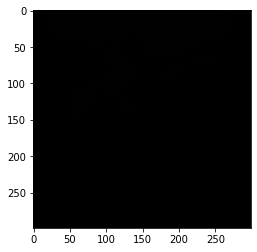

In [46]:
plt.imshow(img)

In [0]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2018-03-18 04:13:41--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 64.207.177.234
Connecting to ccanimalclinic.com (ccanimalclinic.com)|64.207.177.234|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104,37K   194KB/s    in 0,5s    

2018-03-18 04:13:42 (194 KB/s) - ‘data/img.jpg’ saved [106870/106870]



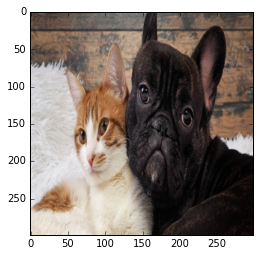

a cat laying down on a bed with a dog .
a cat laying on a bed with a laptop .
a cat laying on a bed with a dog .
a cat laying on a bed with a dog .
a cat laying on a bed in a bed .
a cat laying on a bed with a dog .
a cat laying on a bed with a dog .
a cat laying on a bed with a dog .
a cat laying on a bed with a dog .
a cat laying on a bed with a dog .


In [0]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

In [0]:
# apply your network on images you've found
#
#